In [1]:
# atleast an educated guess 

In [2]:
# Imports
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.linalg import det

from brut_model import BaseModel
from dataset_builders import ScaleCellDataset


import random

# For reproducibility
random_seed = 1869
random.seed(random_seed)

In [3]:

def print_training_history(history, ck_time, title='loss and accuracy evolution'):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(title)

    x = [i * ck_time for i in range(len(history['validation_loss']))]
    ax1.plot(x, history['train_loss'], label='training_loss', alpha=0.5, c='g')
    ax1.plot(x, history['validation_loss'], label='validation_loss', alpha=0.5, c='r')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend()

#     ax2.plot(x, history['train_accuracy'], label='training_accuracy', alpha=0.5, c='g')
#     ax2.plot(x, history['validation_accuracy'], label='validation_accuracy', alpha=0.5, c='r')
#     ax2.set_ylabel('accuracy')
#     ax2.set_xlabel('epoch')
#     ax2.legend()

    return fig


In [4]:
Training_hyper_parameters={
    
    'batch_size':10,
    'validation_split':0.3,
    
    'learning_rate':0.0001,
    'momentum':0.9,
    
    'nr_epochs': 30000, #8001,
    
    'checking_epochs': 10 # Save the model performances once at 10 epochs
}

Model_hyper_parameters={
    'inp_shape':8,
    'output_shape':4
}



In [5]:
# Artificial data 
nr_elements = 1000
xa = []
xb = []
ta = []
for i in range(nr_elements):
    ax= [[random.uniform(-1, 20.7),random.uniform(-1, 20.7)],[random.uniform(-1, 20.7),random.uniform(-1, 20.7)]]
    
    #at = [[random.randint(1, 20),random.randint(1, 10)],[random.randint(1, 10),random.randint(1, 20)]]
    at = [[random.randint(1, 20),0],[0,random.randint(1, 20)]]
    bt = [[random.randint(1, 20),0],[0,random.randint(1, 20)]]
    
    bx = np.dot(np.linalg.inv(bt),np.dot(at,ax))
    
    xa.append(ax)
    xb.append(bx)
    ta.append(at)

In [6]:
xa[0]

[[15.869020672853061, 11.922455517212358],
 [13.1917101660962, 12.156955779850394]]

In [7]:


dataset = ScaleCellDataset(xa,xb,ta)

# Split the data 

batch_size = Training_hyper_parameters['batch_size']
validation_split = Training_hyper_parameters['validation_split']
shuffle_dataset = True



# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

## Creating data loaders for trianing and vlaidation:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=len(val_indices),
                                                sampler=valid_sampler)

all_train =torch.utils.data.DataLoader(dataset, batch_size=len(train_indices), sampler=train_sampler)
##  
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 8])
Labels batch shape: torch.Size([10, 4])


## Model

In [8]:
# Prepare a model 

model = BaseModel(Model_hyper_parameters) # The model that we wish to train.

print('The model:')
print(model)

print('\n\nModel params:')
for param in model.parameters():
    print(param)

The model:
BaseModel(
  (linear1): Linear(in_features=8, out_features=16, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=4, bias=True)
)


Model params:
Parameter containing:
tensor([[ 0.2955,  0.1560, -0.1023,  0.0264,  0.2278, -0.2106, -0.0291, -0.0579],
        [-0.2094, -0.2736,  0.1472,  0.2859,  0.1146,  0.3113,  0.0058, -0.2609],
        [-0.0060, -0.1449, -0.2452, -0.0403, -0.1429,  0.1769,  0.0416, -0.2079],
        [ 0.1193, -0.1650, -0.1913, -0.1912,  0.3227, -0.0225,  0.1533, -0.3361],
        [ 0.1664, -0.2252, -0.0517, -0.2314,  0.1049,  0.3310,  0.1695, -0.0242],
        [-0.0874, -0.1912, -0.1923,  0.3179, -0.3006, -0.3075,  0.3365,  0.0455],
        [ 0.3501,  0.3055, -0.1277,  0.1748, -0.3239,  0.1410,  0.2896,  0.0570],
        [-0.0853, -0.17

## Training 

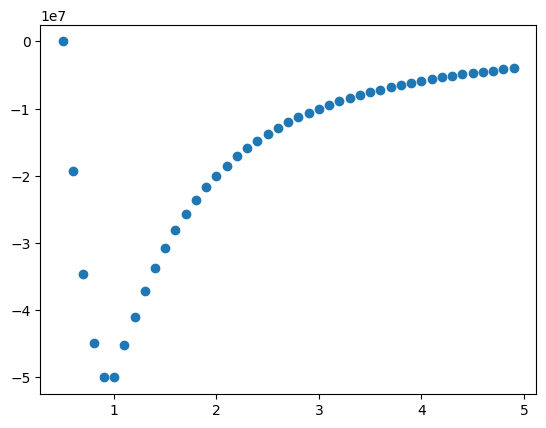

In [9]:
def at_sin(x, up =99999999):
    
    tr_x= (x + 0.5)
    
    if x<1:
        res = up*(1/(1+torch.sqrt((x**2))) )* torch.sin(tr_x*np.pi) +1/(x+0.00000000000001)
    else:
        res = (x-1)**2 -up*(1/(1+x**2))+1/(x+0.00000000000001)
    return res

X = torch.tensor([i*0.1 for i in range(0,50,1)])
Y= [at_sin(x) for x in X]

plt.scatter(X[5:],Y[5:])

In [10]:
def tAtB(params,a,b):
    tA = torch.tensor([[params[0],params[1]],
                   [params[2],params[3]]])
    
    tB = torch.mm(torch.mm(tA,a), torch.inverse(b)) # tAa=tBb
    
    return tA, tB

In [11]:
def fit_fucntion(params ,a,b, k_p=999,strain_boundery =[[-0.2e-9,0.2e-9],[-0.2e-9,0.2e-9]]):
          
        tA, tB= tAtB(params,a,b)
        tAa= torch.mm(tA,a)
        tBb= torch.mm(tB,b)
        
        
#         # Strain tunning 
#         strain = streined_proces(tB,strain_boundery)
#         tB= np.dot(strain,tB)
        
        
#         # main condition
#         zero_mat= tAa - tBb
#         s=0
#         for row in zero_mat:
#             for e in row:
#                 s+=e*e
        
        # mimimum TA
        detTAa= det(tAa)*det(tAa) # minimum but biger than 0
        detTBb= det(tBb)*det(tBb)
        
        # TB integer 
        cons =99999
        tB_con = 0  
        for row in tB:
            for e in row:
                tB_con += ((torch.round(e)-e))*((torch.round(e)-e)) # e*e
        tB_con = tB_con*cons
        
        tA_lenghth =((tA[0][0]**2+tA[0][1]**2)+(tA[1][0]**2+tA[1][1]**2) )*100
        
        
        f =  at_sin(detTAa)+ tB_con**2 +tA_lenghth
        f= torch.autograd.Variable(f, requires_grad=True)
        
        
        return f

In [12]:
#Loss function
def loss(output, x):
#     print("o",output)
#     print("t",target)
    cost =0 
#     print("x",x)
#     print("output", output)
    for i in range(len(output)):
#         print("xi",x[i])
        k= output[i]
        a= torch.tensor([[x[i][0],x[i][1] ], [x[i][2],x[i][3] ]])
        b= torch.tensor([[x[i][4],x[i][5] ], [x[i][6],x[i][7] ]])
        c = fit_fucntion(k,a,b)
        cost+=c
#     cost = torch.sum(a)
    #print("c",cost)
    return cost

criterion = loss # nn.CrossEntropyLoss()

# Optimizer
learning_rate = Training_hyper_parameters['learning_rate']
momentum = Training_hyper_parameters['momentum']                             
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [13]:
# actual training 

## Work in progress ##

nr_epochs = Training_hyper_parameters['nr_epochs']
ck_time = Training_hyper_parameters['checking_epochs']

history = {'train_loss':[],'validation_loss':[], 'train_accuracy':[] , 'validation_accuracy':[]}

for epoch in range(nr_epochs):  
    model.train(True)
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, inputs) # inputs instead of labels 
        train_loss += loss/len(train_loader)
        loss.backward()
        optimizer.step()
    
    if epoch%100 == 0:
        print('Epoch {}| loss:{}'.format(epoch + 1,train_loss ))
    
    if epoch % ck_time == 0:
        
        #training
        for i, data in enumerate(all_train):
            inputs_t, labels_t = data
            outputs_t = model(inputs_t)
            
            tl = criterion(outputs_t, inputs_t).detach().numpy()
            
        
        history['train_loss'].append(tl)
       
        #validation
        for i, data in enumerate(validation_loader):
            inputs_v, labels_v = data
            outputs_v = model(inputs_v)
#         print("aici")
        vl = criterion(outputs_v, inputs_v).detach().numpy()
        
        history['validation_loss'].append(vl)
        
        
        
print('-Training finished-')

Epoch 1| loss:673061036621824.0
Epoch 101| loss:673061305057280.0
Epoch 201| loss:673061170839552.0
Epoch 301| loss:673061036621824.0
Epoch 401| loss:673061036621824.0
Epoch 501| loss:673061170839552.0
Epoch 601| loss:673060969512960.0
Epoch 701| loss:673060969512960.0
Epoch 801| loss:673061103730688.0
Epoch 901| loss:673060969512960.0
Epoch 1001| loss:673061103730688.0
Epoch 1101| loss:673061237948416.0
Epoch 1201| loss:673061170839552.0
Epoch 1301| loss:673060969512960.0
Epoch 1401| loss:673061237948416.0
Epoch 1501| loss:673061103730688.0
Epoch 1601| loss:673061170839552.0
Epoch 1701| loss:673061170839552.0
Epoch 1801| loss:673061103730688.0
Epoch 1901| loss:673061036621824.0
Epoch 2001| loss:673060902404096.0
Epoch 2101| loss:673061036621824.0
Epoch 2201| loss:673061036621824.0
Epoch 2301| loss:673061036621824.0
Epoch 2401| loss:673061036621824.0
Epoch 2501| loss:673061036621824.0
Epoch 2601| loss:673061237948416.0
Epoch 2701| loss:673061170839552.0
Epoch 2801| loss:673061103730688

KeyboardInterrupt: 

In [ ]:
ck_time

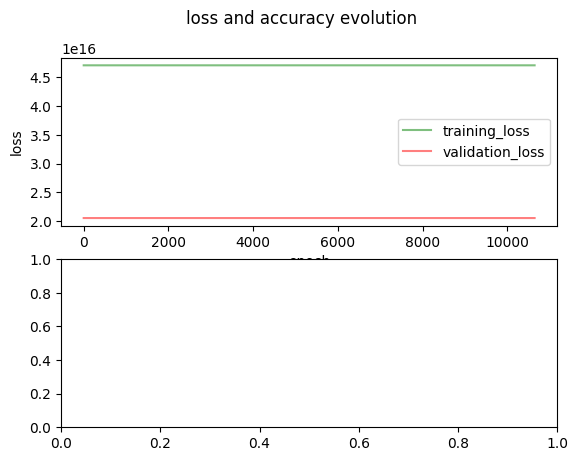

In [14]:
# Training evolution:

fig_trainig_evolution = print_training_history(history, ck_time)

# print("\nModel performance:")
# for k in history:
#     print("{}".format(k),history[k][len(history[k])-1])
# print("__________________")

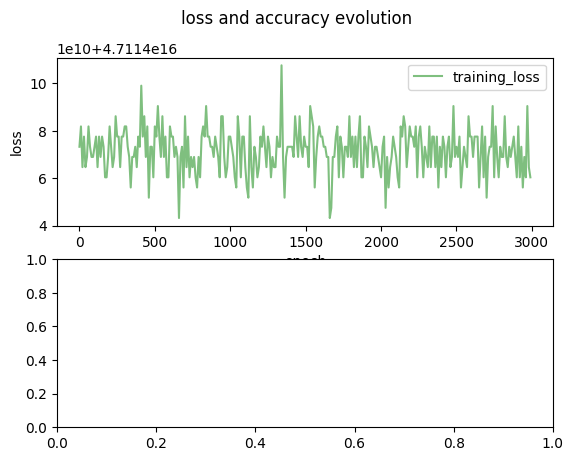

In [16]:


def print_training_history(history, ck_time, title='loss and accuracy evolution', cut=400):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(title)

    x = [i * ck_time for i in range(len(history['validation_loss'][100:cut]))]
    ax1.plot(x, history['train_loss'][100:cut], label='training_loss', alpha=0.5, c='g')
   # ax1.plot(x, history['validation_loss'][100:cut], label='validation_loss', alpha=0.5, c='r')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend()
    
fig_trainig_evolution = print_training_history(history, ck_time)

In [ ]:
a = np.array([[0,1],[1,0]])
b = np.array([[0,5],[5,0]])
xa_v= torch.tensor([0.0,1.0,1.0,0.0,0.0,5.0,5.0,0.0])
outputs_v = model(xa_v)
print(torch.reshape(outputs_v,(2,2)))